# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
%%capture --no-display
!pip install lifetimes
!pip install -U yellowbrick

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from utilities import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory data analysis
### profile.json
Rewards program users (17000 users x 5 fields)

* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* became_member_on: (date) format YYYYMMDD
* income: (numeric)

### portfolio.json
Offers sent during 30-day test period (10 offers x 6 fields)

* reward: (numeric) money awarded for the amount spent
* channels: (list) web, email, mobile, social
* difficulty: (numeric) money required to be spent to receive reward
* duration: (numeric) time for offer to be open, in days
* offer_type: (string) bogo, discount, informational
* id: (string/hash)

### transcript.json
Event log (306648 events x 4 fields)

* person: (string/hash)
* event: (string) offer received, offer viewed, transaction, offer completed
* value: (dictionary) different values depending on event type
  * offer id: (string/hash) not associated with any "transaction"
  * amount: (numeric) money spent in "transaction"
  * reward: (numeric) money gained from "offer completed"
* time: (numeric) hours after start of test

In [4]:
# Verify dimensions
print('The shape of profile is', profile.shape)
print('The shape of portfolio is', portfolio.shape)
print('The shape of transcript is', transcript.shape)

The shape of profile is (17000, 5)
The shape of portfolio is (10, 6)
The shape of transcript is (306534, 4)


## Clean profile data

In [5]:
# Visualise several rows of the data table
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
# Some entries are missing, so we need to get an idea of the percentage of missing
for cols in profile:
    print('Percentage of missing in {} is {}'.format(cols, profile[cols].isna().sum()/17000))

Percentage of missing in gender is 0.12794117647058822
Percentage of missing in age is 0.0
Percentage of missing in id is 0.0
Percentage of missing in became_member_on is 0.0
Percentage of missing in income is 0.12794117647058822


In [7]:
# We are only interested in customer instances where income is present
profile = profile[profile['income'].notnull()]

In [8]:
# Note that for some customers, gender is unspecified - we need to remove those
profile = profile[profile['gender'] != 'O']
profile = profile.reset_index(drop=True)

In [9]:
# We plan to merge the tables later, so need to rename column names to represent customer id
profile = profile.rename({'id': 'customer_id'}, axis='columns')

In [10]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [11]:
profile.describe()

,age,became_member_on,income
count,14613.000000,1.461300e+04,14613.000000
mean,54.393417,2.016687e+07,65435.707931
std,17.400201,1.189517e+04,21633.524110
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [12]:
# specify order of columns
##
# col_order = ['customer_id', 'gender', 'income']

In [13]:
def start_year(became_member_on):
    '''
    Change date(int) to year(int)
    '''
    return int(str(became_member_on)[:4])

In [14]:
# Transform the 'became_member_on' column to a datetime object
profile['became_member_on'] = profile['became_member_on'].apply(start_year)
profile = profile.rename({'became_member_on':'start_year'}, axis='columns')

In [15]:
profile.head()

,gender,age,customer_id,start_year,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0


In [16]:
# One hot encode start year
start_year_ohe = pd.get_dummies(profile['start_year'])
start_year_ohe.head()

,2013,2014,2015,2016,2017,2018
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,1,0


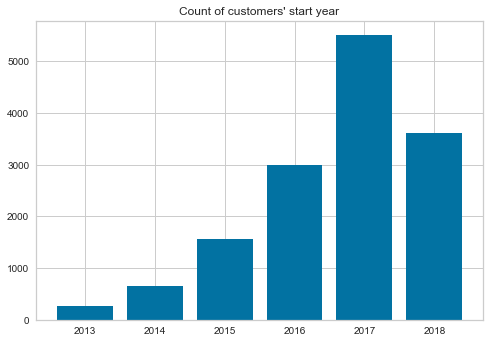

In [17]:
# visualise start year
plt.bar(start_year_ohe.columns, start_year_ohe.sum());
plt.title('Count of customers\' start year');

In [18]:
# min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
# max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

# profile['agerange'] = pd.cut(profile['age'], (range(min_age_limit,max_age_limit + 10, 10)),right=False)

# profile['agerange'] = profile['agerange'].astype('str')

# agerange_df = pd.get_dummies(profile['agerange'])
# column_ordering.extend(agerange_df.columns.values)

In [19]:
# Make gender binary indicators
binariser = LabelBinarizer()
profile['gender'] = binariser.fit_transform(profile['gender'])

In [20]:
# see how the gender mapping goes
gender_dict = {}
for cls in binariser.classes_:
    gender_dict[cls] = binariser.transform([cls])[0,0]
gender_dict

{'F': 0, 'M': 1}

In [21]:
# Appened one hot encoded age range and membership start year variables
profile = pd.concat([profile, start_year_ohe], axis=1)

In [22]:
profile.head()

,gender,age,customer_id,start_year,income,2013,2014,2015,2016,2017,2018
0,0,55,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,0,0,0,0,1,0
1,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,0,0,0,0,1,0
2,1,68,e2127556f4f64592b11af22de27a7932,2018,70000.0,0,0,0,0,0,1
3,1,65,389bc3fa690240e798340f5a15918d5c,2018,53000.0,0,0,0,0,0,1
4,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0,0,0,0,0,1,0


In [23]:
# remove start_year column
profile = profile.drop(columns=['start_year'])

In [24]:
profile.head()

,gender,age,customer_id,income,2013,2014,2015,2016,2017,2018
0,0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0
1,0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,1,0
2,1,68,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1
3,1,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1
4,1,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0


## Clean portfolio

In [25]:
# Change the name of the 'id' column to 'offerid'
portfolio = portfolio.rename({'id':'offer_id'}, axis='columns')
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [26]:
# offer_type and channels are categorical column, so we apply OHE on those columns
offer_type_ohe = pd.get_dummies(portfolio['offer_type'])

channels_bi = MultiLabelBinarizer()
channels_bi.fit(portfolio['channels'])

channels_ohe = pd.DataFrame(channels_bi.transform(portfolio['channels']), columns=channels_bi.classes_)

In [27]:
offer_type_ohe.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [28]:
channels_ohe.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [29]:
# merge the binary columns back to the portfolio dataframe
portfolio = pd.concat([portfolio, offer_type_ohe, channels_ohe], axis=1)

In [30]:
portfolio = portfolio.drop(columns=['offer_type', 'channels'])

In [31]:
portfolio

,reward,difficulty,duration,offer_id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


## Clean transcript data

In [32]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [33]:
# rename person to customer_id
transcript = transcript.rename({'person': 'customer_id'}, axis='columns')
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [34]:
print('Number of unique customer ids in transcript is', len(set(transcript['customer_id'].unique())))

Number of unique customer ids in transcript is 17000


In [35]:
print('Number of unique customer ids in profile is', len(set(profile['customer_id'].unique())))

Number of unique customer ids in profile is 14613


In [36]:
# only keep instances where customer id is in profile dataframe,
# and let's see how many instances are kept
original_row_count = transcript.shape[0]
transcript = transcript[transcript['customer_id'].isin(profile['customer_id'])]
new_row_count = transcript.shape[0]
print('{} % of data is kept'.format(100*new_row_count/original_row_count))

87.68717336412926 % of data is kept


In [37]:
transcript.describe()

,time
count,268791.000000
mean,366.825139
std,200.345114
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [38]:
# since time is measured in hours here, let's convert the numebers to days
transcript['time'] = transcript['time']/24.0
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.0


In [39]:
transcript.describe()

,time
count,268791.000000
mean,15.284381
std,8.347713
min,0.000000
25%,7.750000
50%,17.000000
75%,22.000000
max,29.750000


In [40]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [41]:
# We want only offer data, in other words, we create an offer data table by removing transcations
offer_log = transcript[transcript.event != 'transaction'].copy()

In [42]:
offer_log.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.0


In [43]:
# We see that value of offer is in the form of a dictionary, so we need to transform that
# To conform with the nomenclature we had before, we should create an "offer_id" column
offer_log['offer_id'] = offer_log['value'].apply(lambda cell: list(cell.values())[0])
offer_log.head()

,customer_id,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0.0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0.0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [44]:
# drop and reset index
offer_log = offer_log.drop(columns=['value'])
offer_log = offer_log.reset_index(drop=True)
offer_log.head()

,customer_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [45]:
# apply OHE on event type
event_ohe = pd.get_dummies(offer_log['event'])
event_ohe.head()

,offer completed,offer received,offer viewed
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [46]:
# merge the OHE back to offer_log dataframe
offer_log = pd.concat([offer_log, event_ohe], axis=1)
offer_log = offer_log.drop(columns=['event'])
offer_log.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [47]:
# create transaction dataframe
trans_data = transcript[transcript.event == 'transaction'].copy()
trans_data.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0.0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0.0


In [48]:
# get the values out of the dictionaries
trans_data['transaction_value'] = trans_data['value'].apply(lambda cell: list(cell.values())[0])
trans_data.head()

,customer_id,event,value,time,transaction_value
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0.0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0.0,18.97


In [49]:
# drop event and value columns, we don't need those anymore
trans_data = trans_data.drop(columns=['value', 'event'])
trans_data.head()

,customer_id,time,transaction_value
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [50]:
trans_data = trans_data.reset_index(drop=True)
trans_data.head()

,customer_id,time,transaction_value
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


## Merge the data sets and save data

In [51]:
final_data_path = './data/final_data.csv'
if os.path.exists(final_data_path):
    data_final_df = pd.read_csv(final_data_path)
else:
    # initialise final data as a list, which will later convert to dataframe
    data_final = []
    # iterate through all customer ids based on profile data (cleaned)
    for ids in profile['customer_id'].unique():
        # extract customer info for the particular customer id
        temp_profile = profile[profile['customer_id'] == ids]
        # extract offer info for particular customer id
        temp_offer = offer_log[offer_log['customer_id'] == ids].drop(columns=['customer_id']).reset_index(drop=True)
        # extract transaction information
        temp_trans = trans_data[trans_data['customer_id'] == ids].drop(columns=['customer_id']).reset_index(drop=True)
        # extract info for offer events, i.e. received, viewed, and completed
        event_cols = ['offer received', 'offer viewed', 'offer completed']
        off_rec_df = temp_offer[temp_offer['offer received'] == 1].drop(columns=event_cols).reset_index(drop=True)
        off_view_df = temp_offer[temp_offer['offer viewed'] == 1].drop(columns=event_cols).reset_index(drop=True)
        off_comp_df = temp_offer[temp_offer['offer completed'] == 1].drop(columns=event_cols).reset_index(drop=True)
        # track the offer lifecycle to put into dataframe
        temp_instance = []
        # iterate through all the offers
        for iters in range(off_rec_df.shape[0]):
            # get info associated with the current row
            temp_offer_id = off_rec_df.iloc[iters]['offer_id']
            temp_offer_info = portfolio.loc[portfolio['offer_id'] == temp_offer_id].copy()
            # extract start time
            temp_offer_start = off_rec_df.iloc[iters]['time']
            # compute end time using duration info
            temp_duration = temp_offer_info['duration'].values[0]
            temp_offer_end = temp_offer_start + temp_duration
            # use the time frame to track all the events
            # with the events we can determine whether the offer is successful
            this_offer_view = off_view_df[off_view_df['offer_id'] == temp_offer_id]
            offer_view_label = 0
            for time in this_offer_view[this_offer_view['time'] >= temp_offer_start]['time']:
                if time <= temp_offer_end:
                    offer_view_label = 1
                    break
            this_offer_comp = off_comp_df[off_comp_df['offer_id'] == temp_offer_id]
            offer_comp_label = 0
            for time in this_offer_comp[this_offer_comp['time'] >= temp_offer_start]['time']:
                if time <= temp_offer_end:
                    offer_comp_label = 1
                    break
            # offer_view_label = (off_view_df[off_view_df['offer_id' == temp_offer_id]]['time'] >= temp_offer_start) and (offer_view_df['time'] <= temp_offer_end)
            # offer_comp_label = (off_comp_df['time'] >= temp_offer_start) and (offer_comp_df['time'] <= temp_offer_end)

            # extract transaction info
            temp_trans_sum = 0
            for row_num in range(temp_trans.shape[0]):
                this_time = temp_trans.iloc[row_num]['time']
                if this_time >= temp_offer_start and this_time <= temp_offer_end:
                    temp_trans_sum += temp_trans.iloc[row_num]['transaction_value']
            # related_trans = temp_trans[temp_trans['time'] >= temp_offer_start and temp_trans['time'] <= temp_offer_end]
            # put all the information into a dictionary
            temp_dict = {'customer_id': ids, 'offer_id': off_rec_df.iloc[iters]['offer_id'],
                             'offer_start_time': temp_offer_start,
                             'transaction amount': temp_trans_sum,
                             'success_label': offer_view_label * offer_comp_label}
            # append related customer info and offer info
            temp_dict.update(temp_profile.iloc[0,0:].to_dict())
            temp_dict.update(temp_offer_info.iloc[0,0:].to_dict())
            # add dictionary to the current list
            temp_instance.append(temp_dict)
        data_final.extend(temp_instance)
    data_final_df = pd.DataFrame(data_final)
    data_final_df.to_csv(final_data_path, index=False)

In [52]:
data_final_df.head()

,customer_id,offer_id,offer_start_time,transaction amount,success_label,gender,age,income,2013,2014,...,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,23.22,0,0,55,112000.0,0,0,...,5,5,7,1,0,0,1,1,0,1
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,21.0,23.22,0,0,55,112000.0,0,0,...,0,0,4,0,0,1,1,1,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,37.67,1,0,75,100000.0,0,0,...,5,5,7,1,0,0,1,1,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,7.0,49.39,0,0,75,100000.0,0,0,...,0,0,3,0,0,1,1,1,1,0
4,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,17.0,48.28,1,0,75,100000.0,0,0,...,10,10,7,1,0,0,1,1,1,0


## Analysis on final data set

### Success rate based on gender

In [53]:
gender_success = data_final_df.groupby(['gender', 'success_label']).size()
gender_success.head()

gender  success_label
0       0                14836
        1                12620
1       0                24339
        1                13790
dtype: int64

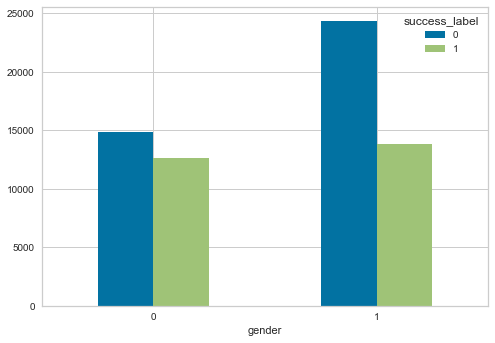

In [54]:
gender_success.unstack().plot.bar(rot=0);

### Success rate based on age

In [55]:
success_age = data_final_df[data_final_df['success_label'] == 1]['age']
unsuccess_age = data_final_df[data_final_df['success_label'] == 0]['age']

In [56]:
data_final_df[['age']].describe()

,age
count,65585.000000
mean,54.364245
std,17.412684
min,18.000000
25%,42.000000
50%,55.000000
75%,66.000000
max,101.000000


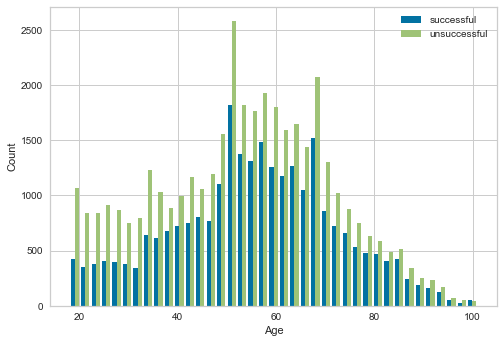

In [57]:
bins = np.linspace(18, 101, 40)
plt.hist([success_age, unsuccess_age], bins, label=['successful', 'unsuccessful'])
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [58]:
age_ranked_df = data_final_df.sort_values(by='age')

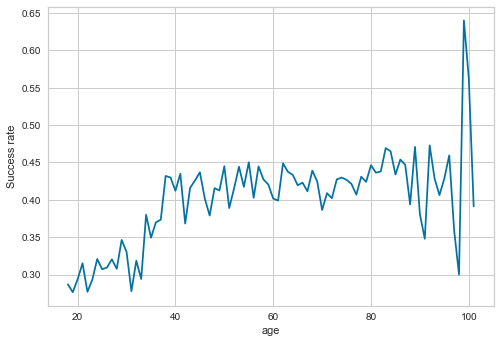

In [59]:
success_count = []
for ages in age_ranked_df['age'].unique():
    temp_df = age_ranked_df[age_ranked_df['age'] == ages]
    success_count.append(temp_df['success_label'].sum()/temp_df.shape[0])
plt.plot(pd.DataFrame({'success rate': success_count}, index=age_ranked_df['age'].unique()))
plt.xlabel('age')
plt.ylabel('Success rate')
plt.show()

### success rate based on offers

In [60]:
offer_id_success = data_final_df.groupby(['offer_id', 'success_label']).size()
offer_id_success

offer_id                          success_label
0b1e1539f2cc45b7b9fa7c272da2e1d7  0                5067
                                  1                1560
2298d6c36e964ae4a3e7e9706d1fb8c2  0                1889
                                  1                4674
2906b810c7d4411798c6938adc9daaa5  0                3992
                                  1                2551
3f207df678b143eea3cee63160fa8bed  0                6561
4d5c57ea9a6940dd891ad53e9dbe8da0  0                3360
                                  1                3161
5a8bc65990b245e5a138643cd4eb9837  0                6544
9b98b8c7a33c4b65b9aebfe6a799e6d9  0                4012
                                  1                2572
ae264e3637204a6fb9bb56bc8210ddfd  0                3421
                                  1                3169
f19421c1d4aa40978ebb69ca19b0e20d  0                2588
                                  1                3900
fafdcd668e3743c1bb461111dcafc2a4  0                1741


In [61]:
offer_num_dict = portfolio[['offer_id']].T.to_dict('records')[0]

In [62]:
offer_num_dict = {value:key for key, value in offer_num_dict.items()}

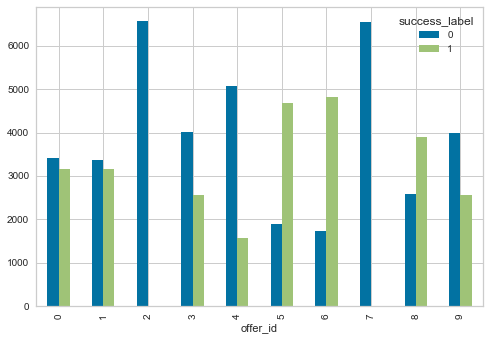

In [63]:
offer_id_success.rename(index=offer_num_dict).sort_index().unstack().plot.bar();

### report demographics for both successful and unsuccessful offers

In [64]:
def demographics(offer_id, key=1):
    '''
    Get stats for successful / unsuccessful groups for each offer
    
    Input: key(int): 1 for successful, 0 for unsuccessful
    Returns: print out statistics for the group
    '''
    temp_df = data_final_df[data_final_df['offer_id'] == offer_id]
    temp_df = temp_df[temp_df['success_label'] == key]
    print('Percentage of male: {:.2f}%'.format(100 * temp_df['gender'].sum() / temp_df.shape[0]))
    print('Average age: {:.2f}'.format(temp_df['age'].mean()))
    print('Average income: {:.2f}'.format(temp_df['income'].mean()))
    print('Average transaction value: {:.2f}'.format(temp_df['transaction amount'].mean()))

In [65]:
for offer_ids in portfolio['offer_id'].unique():
    print('=' * 30)
    print('Offer ID: {}\n'.format(offer_ids))
    temp_df = data_final_df[data_final_df['offer_id'] == offer_ids]
    success_rate = temp_df['success_label'].sum() / temp_df.shape[0]
    print('Success rate = {:.2f}%\n'.format(100 * success_rate))
    if success_rate > 0:
        # Success demographics
        print('Successful offer:')
        print('-' * 20)
        demographics(offer_id=offer_ids, key=1)
        print('')
    # Unsuccessful demographics
    print('Unsuccessful offer:')
    print('-' * 20)
    demographics(offer_id=offer_ids, key=0)
    print('=' * 30)
    print('')

Offer ID: ae264e3637204a6fb9bb56bc8210ddfd

Success rate = 48.09%

Successful offer:
--------------------
Percentage of male: 48.88%
Average age: 56.10
Average income: 70708.11
Average transaction value: 59.52

Unsuccessful offer:
--------------------
Percentage of male: 66.97%
Average age: 52.46
Average income: 60933.06
Average transaction value: 12.33

Offer ID: 4d5c57ea9a6940dd891ad53e9dbe8da0

Success rate = 48.47%

Successful offer:
--------------------
Percentage of male: 46.50%
Average age: 56.85
Average income: 72575.77
Average transaction value: 50.91

Unsuccessful offer:
--------------------
Percentage of male: 68.87%
Average age: 51.77
Average income: 58784.52
Average transaction value: 6.28

Offer ID: 3f207df678b143eea3cee63160fa8bed

Success rate = 0.00%

Unsuccessful offer:
--------------------
Percentage of male: 58.10%
Average age: 54.53
Average income: 65169.33
Average transaction value: 15.90

Offer ID: 9b98b8c7a33c4b65b9aebfe6a799e6d9

Success rate = 39.06%

Successf

## Train test split the data

In [66]:
# set target variable
target = data_final_df.filter(['success_label'])

In [67]:
# set feature space
features = data_final_df.drop(columns=['offer_id', 'customer_id', 'success_label'])

In [68]:
# Train-test split the data
(X_train, X_test, y_train, y_test) = train_test_split(features.values, target.values, test_size=.2, random_state=8)

In [69]:
feature_names = features.columns

In [70]:
# see which features need to be transformed
features.describe()

,offer_start_time,transaction amount,gender,age,income,2013,2014,2015,2016,2017,...,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
count,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,...,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.0,65585.000000,65585.000000,65585.000000
mean,13.861904,30.621165,0.581368,54.364245,65402.470077,0.018510,0.045132,0.107113,0.204102,0.377312,...,4.200778,7.715499,6.507448,0.399222,0.400961,0.199817,1.0,0.898956,0.598765,0.799741
std,8.187460,57.855073,0.493339,17.412684,21655.610947,0.134789,0.207596,0.309259,0.403047,0.484718,...,3.399038,5.545371,2.204051,0.489742,0.490097,0.399866,0.0,0.301390,0.490152,0.400197
min,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,7.000000,2.260000,0.000000,42.000000,49000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,5.000000,5.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,17.000000,16.240000,1.000000,55.000000,64000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,10.000000,7.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,21.000000,40.390000,1.000000,66.000000,80000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,5.000000,10.000000,7.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000
max,24.000000,1200.990000,1.000000,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [71]:
binary_features = features.loc[:,features.isin([0,1]).all()]

In [72]:
binary_features.head()

,gender,2013,2014,2015,2016,2017,2018,bogo,discount,informational,email,mobile,social,web
0,0,0,0,0,0,1,0,1,0,0,1,1,0,1
1,0,0,0,0,0,1,0,0,0,1,1,1,0,1
2,0,0,0,0,0,1,0,1,0,0,1,1,0,1
3,0,0,0,0,0,1,0,0,0,1,1,1,1,0
4,0,0,0,0,0,1,0,1,0,0,1,1,1,0


In [73]:
binary_features.describe()

,gender,2013,2014,2015,2016,2017,2018,bogo,discount,informational,email,mobile,social,web
count,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.0,65585.000000,65585.000000,65585.000000
mean,0.581368,0.018510,0.045132,0.107113,0.204102,0.377312,0.247831,0.399222,0.400961,0.199817,1.0,0.898956,0.598765,0.799741
std,0.493339,0.134789,0.207596,0.309259,0.403047,0.484718,0.431756,0.489742,0.490097,0.399866,0.0,0.301390,0.490152,0.400197
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [74]:
# email is always 1, let's remove email
binary_features = binary_features.drop(columns=['email'])

In [75]:
non_binary_features = features.drop(columns=list(binary_features.columns.values)).copy()
non_binary_features.head()

,offer_start_time,transaction amount,age,income,reward,difficulty,duration,email
0,17.0,23.22,55,112000.0,5,5,7,1
1,21.0,23.22,55,112000.0,0,0,4,1
2,0.0,37.67,75,100000.0,5,5,7,1
3,7.0,49.39,75,100000.0,0,0,3,1
4,17.0,48.28,75,100000.0,10,10,7,1


In [76]:
# perform feature transformations
features_to_norm = list(non_binary_features.columns.values)
min_max_scaler = {}
for index in range(len(features_to_norm)):
    col_num = np.argwhere(feature_names == features_to_norm[index])[0, 0]
    this_col = features_to_norm[index]
    min_max_scaler[this_col] = MinMaxScaler()
    min_max_scaler[this_col].fit(X_train[:,col_num].reshape(-1, 1))
    new_train_vals = min_max_scaler[this_col].transform(X_train[:,col_num].reshape(-1, 1))
    X_train[:,col_num] = new_train_vals.reshape(1, -1)
    new_test_vals = min_max_scaler[this_col].transform(X_test[:,col_num].reshape(-1, 1))
    X_test[:,col_num] = new_test_vals.reshape(1, -1)

In [77]:
# confirm ranges
print('Training data range is [{}, {}].'.format(X_train.min(),X_train.max()))
print('Testing data range is [{}, {}].'.format(X_test.min(),X_test.max()))

Training data range is [0.0, 1.0].
Testing data range is [0.0, 1.0].


# Modelling

### Benchmark performance

In [78]:
for j in [0, 1]:
    train_pred = j * np.ones(len(y_train))
    test_pred = j * np.ones(len(y_test))
    print('Predict everything as {}\n'.format(j) + '-'*25)
    print('Training:')
    print('Accuracy is {:.3f}'.format(accuracy_score(y_train, train_pred)))
    print('F1-score is {:.3f}'.format(f1_score(y_train, train_pred)))
    print('Testing:')
    print('Accuracy is {:.3f}'.format(accuracy_score(y_test, test_pred)))
    print('F1-score is {:.3f}'.format(f1_score(y_test, test_pred)))
    print('')

Predict everything as 0
-------------------------
Training:
Accuracy is 0.597
F1-score is 0.000
Testing:
Accuracy is 0.597
F1-score is 0.000

Predict everything as 1
-------------------------
Training:
Accuracy is 0.403
F1-score is 0.574
Testing:
Accuracy is 0.403
F1-score is 0.574



### Logistic regression

In [79]:
model_loc = './LogRegModel.joblib'
if os.path.exists(model_loc):
    log_reg_model = load(model_loc)
else:
    model_obj = LogisticRegression(random_state=8, solver='liblinear')
    lr_grid = RandomizedSearchCV(estimator=model_obj,
                                     param_distributions={'C': [0.01, 0.1, 1.0], 'penalty': ['l1', 'l2']},
                                     scoring=make_scorer(fbeta_score, beta=0.5),
                                     n_iter=6,
                                     cv=3,
                                     random_state=8,
                                     n_jobs=3,
                                     verbose=2)
    lr_grid.fit(X_train, y_train)
    dump(lr_grid, model_loc)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    9.2s finished
/Users/Xiaodong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
# Get best model
lr_model = lr_grid.best_estimator_
def report_performance(model):
    # Training performance
    print('Training performance:\n' + '-'*20)
    y_pred = model.predict(X_train)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_train, y_pred)))
    print('F1-score: {:.3f}'.format(f1_score(y_train, y_pred)))
    # Testing performance
    print('\nTesting performance:\n' + '-'*20)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('F1-score: {:.3f}'.format(f1_score(y_test, y_pred)))
    
    return None

report_performance(lr_model)

Training performance:
--------------------
Accuracy: 0.876
F1-score: 0.839

Testing performance:
--------------------
Accuracy: 0.876
F1-score: 0.840


In [81]:
def get_curve_params(y, p):
    '''
    Compute metrics to plot curves
    
    Input: y: target; p: predicted probabilities of success (i.e. pred=1)
    
    Returns: prec - Precision; tpr = True Positive Rate; FPR - False Positive Rate
    '''
    prec = []
    tpr = []
    fpr = []
    for i in range(1000):
        tp = fp = tn = fn = 0
        for j in range(y.size):
            if(p[j] >= i/1000):
                if(y[j] == 1):
                    tp += 1
                else:
                    fp += 1
            else:
                if(y[j] == 0):
                    tn += 1
                else:
                    fn += 1
        prec.append(tp / (tp + fp)) if (tp + fp) != 0 else 0
        tpr.append(tp / (tp + fn)) if (tp + fn) != 0 else 0
        fpr.append(fp / (tn + fp)) if (tn + fp) != 0 else 0
    return prec, tpr, fpr

In [84]:
prec, tpr, fpr = get_curve_params(y_train, lr_model.predict_proba(X_train)[:,1])

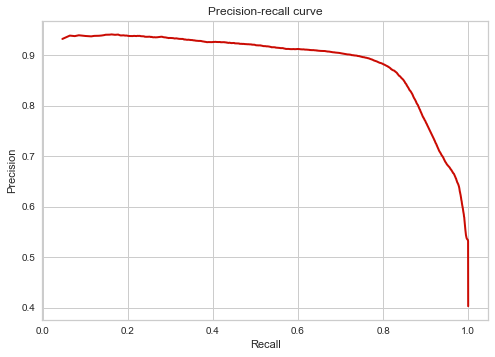

In [85]:
plt.plot(tpr, prec, color='r',lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

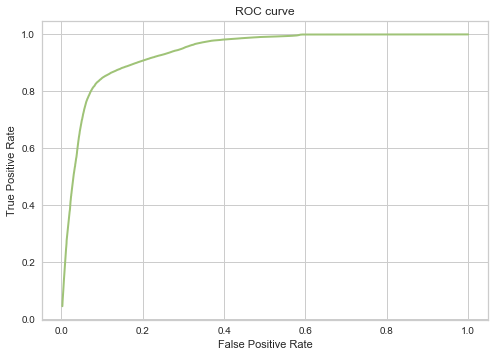

In [86]:
plt.plot(fpr, tpr, color='g',lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Random forest

In [87]:
model_loc = './RandomForestModel.joblib'
if os.path.exists(model_loc):
    rand_forest_model = load(model_loc)
else:
    model_obj = RandomForestClassifier(random_state=8)
    rf_grid = RandomizedSearchCV(estimator=model_obj,
                                 param_distributions={'max_depth': list(np.arange(2, 10)),
                                                      'max_features': ['sqrt', 'auto'],
                                                      'n_estimators': [10, 20, 30, 50, 100, 150, 200],
                                                      'min_samples_split': [2, 5, 10],
                                                      'min_samples_leaf': [1, 2, 4]},
                                 scoring=make_scorer(fbeta_score, beta=0.5),
                                 n_iter=100,
                                 random_state=8,
                                 cv=3,
                                 n_jobs=3,
                                 verbose=2)
    rf_grid.fit(X_train, y_train)
    dump(rf_grid, model_loc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   14.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   48.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  1.5min finished
/Users/Xiaodong/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [88]:
rf_model = rf_grid.best_estimator_
report_performance(rf_model)

Training performance:
--------------------
Accuracy: 0.910
F1-score: 0.893

Testing performance:
--------------------
Accuracy: 0.906
F1-score: 0.888


In [89]:
# compute feature importance
importance = rf_model.feature_importances_

imp_df = pd.DataFrame(list(zip(feature_names, importance)), columns=['feature', 'importance'])
imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
imp_df

,feature,importance
0,transaction amount,0.559011
1,reward,0.168470
2,difficulty,0.067262
3,social,0.052889
4,informational,0.049307
5,income,0.018409
6,duration,0.014417
7,mobile,0.013963
8,2018,0.012614
9,bogo,0.009202
